In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

from time import time

# import galsim

from astropy.io import fits

from forklens.simulation import get_sim

True label:  [ 0.   0.  22.   0.5]


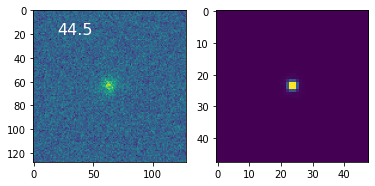

In [2]:
im,psf_im,label,snr = get_sim(gal_pars=[0.,0.,22,0.5],
                    psf_pars=[0,0,1,0.2],
                    shear=None)

print('True label: ',label)
plt.subplot(1,2,1)
plt.imshow(im)
plt.text(20,20,str(round(snr,2)),color='white',fontsize=16)
plt.subplot(1,2,2)
plt.imshow(psf_im)

## Fork Train

### Funcs

In [3]:
class ResidualBlock(nn.Module):
    
    
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        
        super(ResidualBlock,self).__init__()
        
        self.cnn1 =nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
            
            
    def forward(self,x):
        
        residual = x
        
        x = self.cnn1(x)
        x = self.cnn2(x)
        
        x += self.shortcut(residual)
        
        x = nn.ReLU(True)(x)
        return x

    
class ForkCNN(nn.Module):
    
    def __init__(self):
        super(ForkCNN, self).__init__()
        
        ### ResNet34
        self.resnet34 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=3,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.MaxPool2d(3,2),
            ResidualBlock(64,64),
            ResidualBlock(64,64),
            ResidualBlock(64,64,2),
            
            ResidualBlock(64,128),
            ResidualBlock(128,128),
            ResidualBlock(128,128),
            ResidualBlock(128,128,2),
            
            ResidualBlock(128,256),
            ResidualBlock(256,256),
            ResidualBlock(256,256),
            ResidualBlock(256,256),
            ResidualBlock(256,256),
            ResidualBlock(256,256,2),
            
            ResidualBlock(256,512),
            ResidualBlock(512,512),
            ResidualBlock(512,512,2)
        )

        
        self.avgpool = nn.AvgPool2d(2)
        
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.Conv2d(32,64,kernel_size=3,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.Conv2d(64,32,kernel_size=3,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.Conv2d(32,16,kernel_size=3,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        
        ### Fully-connected layers
        self.fully_connected_layer = nn.Sequential(
            nn.Linear(1296, 512),
            nn.Linear(512, 128),
            nn.Linear(128, nFeatures),
        )

    
    def forward(self, x, y):
        
        x = self.resnet34(x)
        x = self.avgpool(x)
        
        #y = self.resnet18(y)
        y = self.cnn_layers(y)
        #y = self.avgpool(y)
        
        # Flatten
        x = x.view(int(BATCH_SIZE/GPU_num),-1)
        y = y.view(int(BATCH_SIZE/GPU_num),-1)
        # print(x.size())
        # print(y.size())
        
        # Concatenation
        z = torch.cat((x, y), -1)
        #z = z.view(-1)
        #print(z.size())
        z = self.fully_connected_layer(z)
        
        return z

In [4]:
class ShapeDataset(Dataset):
    def __init__(self, dataset):
        
        self.classes_frame = dataset

    def __len__(self):
        return self.classes_frame.shape[0]

    def __getitem__(self, idx):

        gal_image, psf_image, label, snr = get_sim(
                gal_pars=self.classes_frame[idx,0:4],
                psf_pars=self.classes_frame[idx,4:8],
                shear=None,
            )
        
        label = np.array([label[0]/np.max(self.classes_frame[:,0]),
                          label[1]/np.max(self.classes_frame[:,1]),
                          label[2]/np.max(self.classes_frame[:,2]),
                          label[3]/np.max(self.classes_frame[:,3])])
        
        return {'gal_image': gal_image[None], 
                'psf_image': psf_image[None], 
                'label': label,
                'snr': snr,
                'id': idx}

In [5]:
def trainFunc():
    model.train()
    losses = []
    epoch_start = time()
    for i, batch in enumerate(train_dl):
        inputs1, inputs2, labels = batch['gal_image'].float().to(device), \
                                   batch['psf_image'].float().to(device), \
                                   batch['label'].float().view(-1,nFeatures).to(device)

        optimizer.zero_grad()             
        outputs = model.forward(inputs1, inputs2)
        # print(outputs[0,:])
        # print(labels[0,:])
        loss = criterion(outputs, labels) 
        losses.append(loss.item())        
        loss = torch.sqrt(loss)           
        loss.backward()                   
        optimizer.step()                  
        
    epoch_loss = np.sqrt(sum(losses) / len(losses))
    epoch_time = time() - epoch_start
    print("[TRAIN] Epoch: {} Loss: {} Time: {:.0f}:{:.0f}".format(epoch+1, epoch_loss,
                                                                  epoch_time // 60, 
                                                                  epoch_time % 60))
    return epoch_loss

def validFunc():
    model.eval()
    losses = []
    epoch_start = time()
    for i, batch in enumerate(valid_dl):
        inputs1, inputs2, labels = batch['gal_image'].float().to(device), \
                                   batch['psf_image'].float().to(device), \
                                   batch['label'].float().view(-1,nFeatures).to(device)
        
        outputs = model.forward(inputs1, inputs2)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        
    epoch_loss = np.sqrt(sum(losses) / len(losses))
    epoch_time = time() - epoch_start
    print("[VALID] Epoch: {} Loss: {} Time: {:.0f}:{:.0f}".format(epoch+1, epoch_loss,
                                                                epoch_time // 60, 
                                                                epoch_time % 60))
    return epoch_loss

### Train

3909454


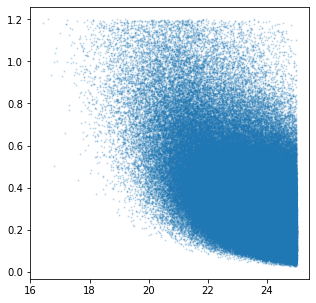

In [6]:
with fits.open('../data/disk_gal_catalog_cut_25_1.2.fits') as f:
    mag_cat = f[0].data
    size_cat = f[3].data
plt.figure(figsize=(5,5))
plt.scatter(mag_cat[::10], size_cat[::10], s=1, alpha=0.2)
print(mag_cat.shape[0])

In [7]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 200
nFeatures = 4
GPU_num = 2

# Device Options
if torch.cuda.is_available():
    DEVICE = "cuda:0" # "cuda" or "cpu"
    NR_DEVICES = torch.cuda.device_count()
else:
    DEVICE = "cpu"
    NR_DEVICES = torch.get_num_threads()    
NR_WORKERS = 8 * NR_DEVICES

def dataframe(num,seed=54321):

    num = int(num/2)
    rng1 = np.random.RandomState(seed)
    Gal_Hlr   = size_cat[rng1.randint(0,mag_cat.shape[0],size=num)]
    Gal_Hlr   = np.concatenate((Gal_Hlr, Gal_Hlr), axis=0)
    Gal_Mag   = mag_cat[rng1.randint(0,mag_cat.shape[0],size=num)]
    Gal_Mag   = np.concatenate((Gal_Mag, Gal_Mag), axis=0)
    # Gal_Flux   = mag2photon(Gal_Mag)
    Gal_e     = rng1.random((num,2))*(-0.6-0.6)+0.6
    Gal_e     = np.concatenate((Gal_e, Gal_e*-1), axis=0)

    rng2 = np.random.RandomState(seed+1)
    PSF_Size  = rng2.random(size=num)*(0.2-0.21)+0.21
    PSF_Size  = np.concatenate((PSF_Size, PSF_Size), axis=0)
    PSF_Flux  = np.ones(num*2)
    PSF_e     = rng2.random((num,2))*(-0.1-0.1)+0.1
    PSF_e     = np.concatenate((PSF_e, PSF_e), axis=0)

    Dataframe        = np.zeros((num*2, 8))
    Dataframe[:,0:2] = Gal_e
    Dataframe[:,2]   = Gal_Mag
    Dataframe[:,3]   = Gal_Hlr
    # Dataframe[:,4]   = Gal_SNR
    Dataframe[:,4:6] = PSF_e*0
    Dataframe[:,6]   = PSF_Flux
    Dataframe[:,7]   = PSF_Size
    
    return Dataframe

nSims = 20000
Dataframe       = dataframe(nSims, 12345)

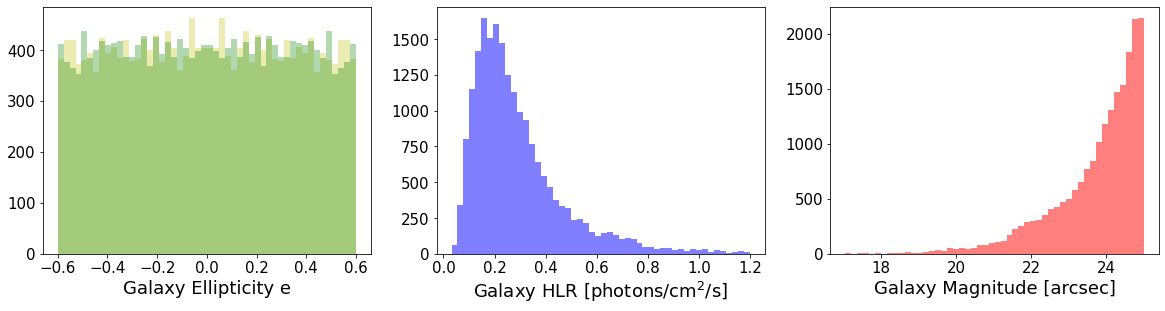

In [8]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.hist(Dataframe[:,0],bins=50,alpha=0.3,color='y');
plt.hist(Dataframe[:,1],bins=50,alpha=0.3,color='g');
#plt.xscale('log')
plt.xlabel('Galaxy Ellipticity e',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,3,2)
plt.hist(Dataframe[:,3],bins=50,alpha=0.5,color='b');
#plt.axvline(0.05,color='k',linestyle='--')
plt.xlabel(r'$\rm Galaxy~HLR~[photons/cm^2/s]$',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,3,3)
plt.hist(Dataframe[:,2],bins=50,alpha=0.5,color='r');
#plt.axvline(0.05,color='k',linestyle='--')
plt.xlabel('Galaxy Magnitude [arcsec]',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)

Train_dl: 90 Validation_dl: 10
Label 200 : [ 0.29396246 -0.89909275  0.995762    0.14243586]
Label 790 : [-0.51586198  0.73046143  0.98311056  0.12396739]
Label 650 : [-0.73458612 -0.24950287  0.92178522  0.3496355 ]
Label 320 : [-0.51166383 -0.41728145  0.99353718  0.20625451]
Label 550 : [0.55205316 0.80013936 0.97139655 0.37688116]


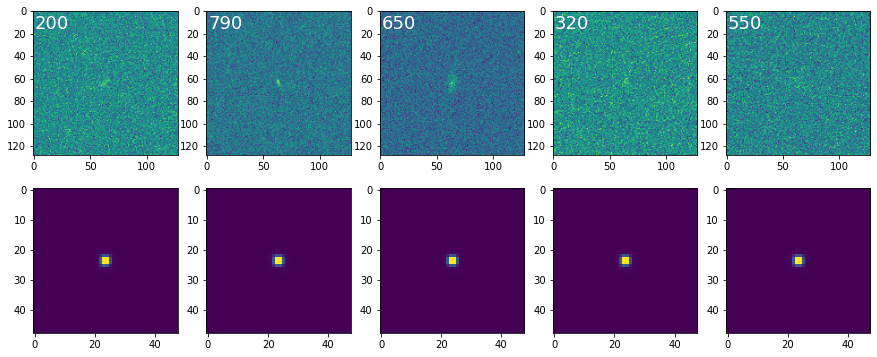

In [9]:
train_ds = ShapeDataset(Dataframe)

size = len(train_ds)
indices = list(range(size))
split = int(np.floor(VALIDATION_SPLIT * size))

train_indices, valid_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_dl = DataLoader(train_ds, 
                      batch_size=BATCH_SIZE, 
                      num_workers=NR_WORKERS,
                      sampler=train_sampler)
valid_dl = DataLoader(train_ds, 
                      batch_size=BATCH_SIZE, 
                      num_workers=NR_WORKERS,
                      sampler=valid_sampler)
print("Train_dl: {} Validation_dl: {}".format(len(train_dl), len(valid_dl)))

plt.figure(figsize=(15, 6))
for i in range(1, 6):
    n = np.random.randint(100)
    out = train_ds.__getitem__(n*10);
    plt.subplot(2, 5, i)
    plt.text(1, 16, str(n*10), fontsize=18, color='w')
    plt.imshow(out['gal_image'][0])
    plt.subplot(2, 5, i+5)
    plt.imshow(out['psf_image'][0])
    print('Label %d :'%(n*10), train_ds.__getitem__(n*10)['label'])

In [12]:
model = ForkCNN()

model = nn.DataParallel(model, device_ids=range(GPU_num))
device = torch.device(DEVICE)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.999))
#optimizer = optim.RMSprop(model.parameters(), lr=0.4, alpha=0.9)
#optimizer = optim.Adadelta(model.parameters(), rho=0.9)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

print('Initial learning rate : 0.01 .')

# Loop the training and validation processes
train_losses = []
valid_losses = []
for epoch in range(600):
    train_loss = trainFunc()
    valid_loss = validFunc()
    scheduler.step(train_loss)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)   
    # Save Models of Checkpoints
    # if (epoch >= 100) & (epoch%10 == 0):
    #     torch.save(model.state_dict(), "./model/resnet34+cnn_SGD_Plateau_20000_200_0.01_nonoise_epoch_"+str(epoch))

Initial learning rate : 0.01 .
[TRAIN] Epoch: 1 Loss: 0.3908322124839617 Time: 0:26
[VALID] Epoch: 1 Loss: 0.4053614233633003 Time: 0:3


KeyboardInterrupt: 

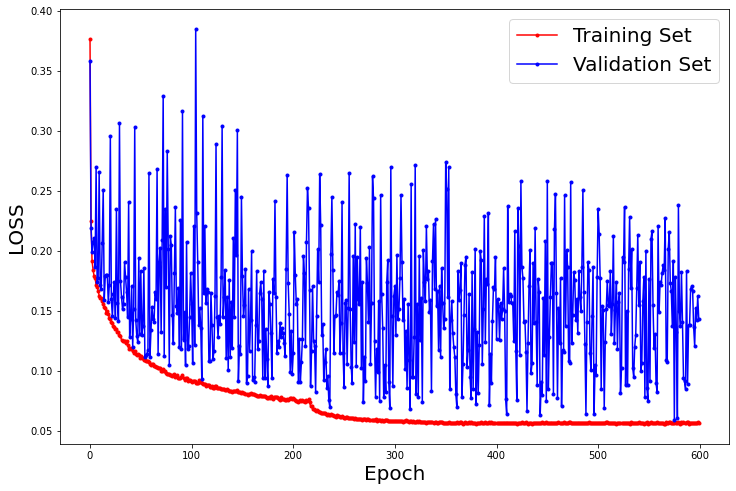

In [11]:
plt.figure(figsize=(12,8))
plt.plot(train_losses, 'r.-', label="Training Set")
plt.plot(valid_losses, 'b.-', label='Validation Set')
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("LOSS", fontsize=20)
#plt.ylim(0.,0.3)
plt.legend(fontsize=20)

In [16]:
def predictFuncs(MODEL, DATALOADER, CRITERION=nn.MSELoss()):
    MODEL.eval()

    losses=[]
    for i, batch in enumerate(DATALOADER):
        inputs1, inputs2 = batch['gal_image'].float().to(device), \
                                   batch['psf_image'].float().to(device)
        outputs = MODEL.forward(inputs1, inputs2)
        labels_true_batch = batch['label'].float().view(-1,nFeatures).to(device)
        loss = CRITERION(outputs, labels_true_batch)
        losses.append(loss.item())
        if i == 0:
            ids = batch['id'].numpy()
            labels = outputs.detach().cpu().numpy()
            labels_true = labels_true_batch.cpu()
            snr = batch['snr'].numpy()
            
        else:
            ids = np.concatenate((ids, batch['id'].numpy()))
            labels = np.vstack((labels, outputs.detach().cpu().numpy()))
            labels_true = np.vstack((labels_true, labels_true_batch.cpu()))  
            snr = np.concatenate((snr, batch['snr'].numpy()))
    
    combined_pred = np.column_stack((ids, labels))
    combined_true = np.column_stack((ids, labels_true))
    combined_snr  = np.column_stack((ids, snr))

    epoch_loss = np.sqrt(sum(losses) / len(losses))
    return combined_pred, combined_true, combined_snr, epoch_loss

In [11]:
device = torch.device(DEVICE)
model_l = ForkCNN()
model_l.to(device)
model_l = nn.DataParallel(model_l, device_ids=range(2))
model_file = "./model/test"
#model_file = "./models/forkcnn/resnet34+cnn_SGD_Plateau_50000_50_0.01_nonoise_epoch_360"
model_l.load_state_dict(torch.load(model_file), strict=False)

FileNotFoundError: [Errno 2] No such file or directory: './model/test'

In [17]:
valid_pred, valid_true, snr_cat, loss_epoch = predictFuncs(model, valid_dl)
print(loss_epoch)

0.20851979891450304


In [19]:
snr_cat

array([[1179.        ,    5.23694186],
       [ 856.        ,   21.01588583],
       [1442.        ,   10.62122506],
       ...,
       [ 534.        ,   13.73989032],
       [1646.        ,   10.18259678],
       [1054.        ,   13.2287095 ]])

(array([465., 462., 259., 154., 107.,  69.,  55.,  54.,  30., 345.]),
 array([ 3.44271562,  8.09844406, 12.7541725 , 17.40990093, 22.06562937,
        26.72135781, 31.37708625, 36.03281469, 40.68854312, 45.34427156,
        50.        ]),
 <BarContainer object of 10 artists>)

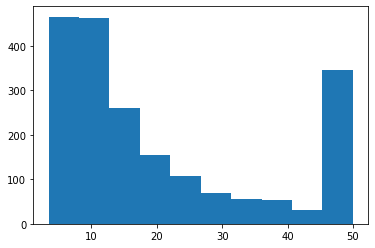

In [21]:
snr_cat[np.where(snr_cat[:,1]>50),1]=50
plt.hist(snr_cat[:,1])

In [ ]:
title = ['gal_e1','gal_e2','gal_hlr','gal_magi']
# title = ['gal_e1','gal_e2',
#          'psf_e1','psf_e2']

plt.figure(figsize=(20,5))
for i in range(nFeatures): 
    plt.subplot(1,4,i+1)
    plt.title(title[i],fontsize=18)
    #plt.plot(valid_true[:,i+1], valid_pred[:,i+1], '.', color=(220/255, 28/255, 19/255),  alpha=0.7, label='Valid')
    plt.scatter(valid_true[:,i+1], valid_pred[:,i+1],color='red')
    #plt.plot(train_true[:,i+1], train_pred[:,i+1], 'g.', alpha=0.1, label='Train')
    plt.plot(valid_true[:,i+1], valid_true[:,i+1], 'k-', linewidth=2)
    plt.tick_params(axis='both',which='major',labelsize=16)
    
#plt.legend(fontsize=18)
plt.tight_layout()